<a href="https://colab.research.google.com/github/Tieck-IT/Study/blob/main/tf_keras/%5Bsegmentation%5Dunet_segmentation_multi_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets

In [2]:
!pip install tfds-nightly

     |████████████████████████████████| 4.1 MB 4.0 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Shuffling lost_and_found-train.tfrecord...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Shuffling lost_and_found-test.tfrecord...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [4]:
dataset = next(iter(ds))

In [5]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [6]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [7]:
print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [8]:
print(np.max(labels), np.min(labels))

38 0


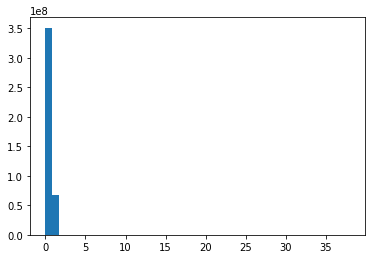

In [9]:
plt.hist(labels.flatten(), bins=45)
plt.show()

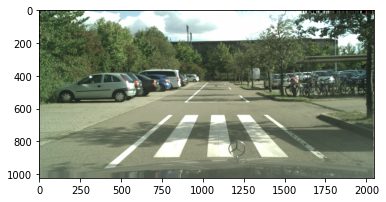

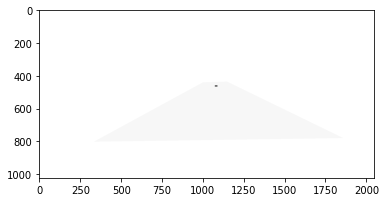

In [10]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

In [11]:
print(labels[0][700,500:550,:].squeeze())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
# from skimage.transform import resize
import cv2

def resize(img):
    return cv2.resize(img, (256,256), interpolation=cv2.INTER_NEAREST)

resized_images = np.array([resize(image) for image in images])
resized_labels = np.array([resize(label) for label in labels])

In [13]:
print(resized_images.shape)
print(resized_labels.shape)

(200, 256, 256, 3)
(200, 256, 256)


In [14]:
x = resized_images.astype(np.float) / 255.
y = resized_labels.astype(np.int)

In [15]:
CATEGORY_COUNT = np.max(y) + 1
print("CATEGORY_COUNT =", CATEGORY_COUNT)

CATEGORY_COUNT = 39


In [16]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [17]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256)
(40, 256, 256, 3)
(40, 256, 256)


train


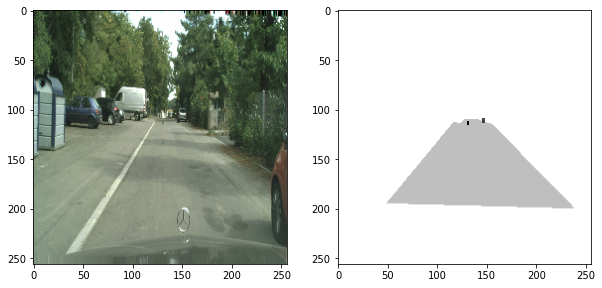

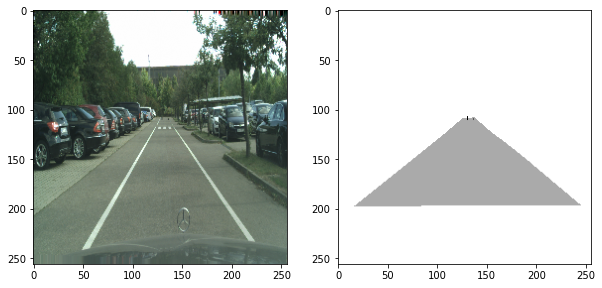

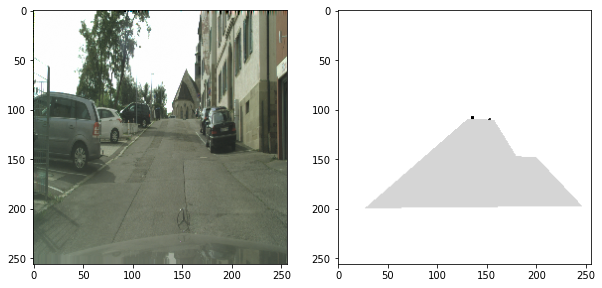

test


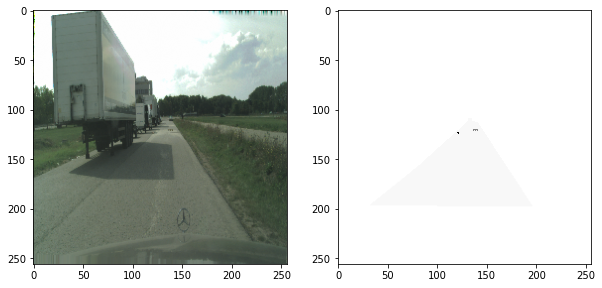

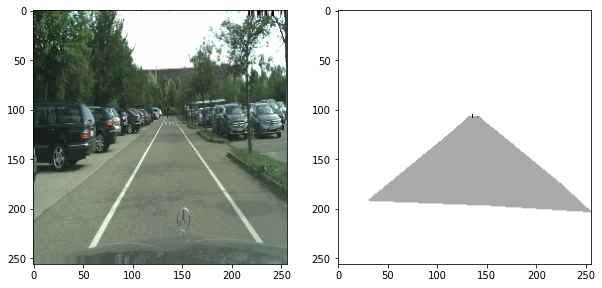

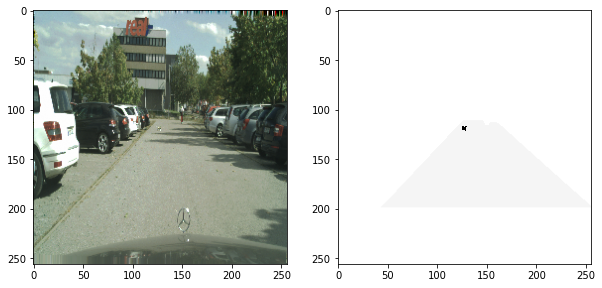

In [18]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        plt.figure(figsize=(10,5))
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'binary') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

In [19]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(category_count, input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(category_count, (1, 1), activation="softmax")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [20]:
model = unet(CATEGORY_COUNT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
# 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=64, verbose=1)


Epoch 1/500
2/2 [==============================] - 21s 4s/step - loss: 4.0472 - accuracy: 0.0300 - val_loss: 3.6451 - val_accuracy: 0.1358
Epoch 2/500
2/2 [==============================] - 1s 819ms/step - loss: 3.6586 - accuracy: 0.1644 - val_loss: 3.6364 - val_accuracy: 0.1279
Epoch 3/500
2/2 [==============================] - 1s 811ms/step - loss: 3.4477 - accuracy: 0.2158 - val_loss: 3.6284 - val_accuracy: 0.0830
Epoch 4/500
2/2 [==============================] - 1s 805ms/step - loss: 3.2581 - accuracy: 0.3226 - val_loss: 3.7466 - val_accuracy: 0.1252
Epoch 5/500
2/2 [==============================] - 1s 803ms/step - loss: 3.0244 - accuracy: 0.4075 - val_loss: 7.9798 - val_accuracy: 0.0411
Epoch 6/500
2/2 [==============================] - 1s 807ms/step - loss: 2.8443 - accuracy: 0.4930 - val_loss: 32.2668 - val_accuracy: 0.0410
Epoch 7/500
2/2 [==============================] - 1s 809ms/step - loss: 2.7140 - accuracy: 0.5635 - val_loss: 117.9799 - val_accuracy: 0.0887
Epoch 8/500


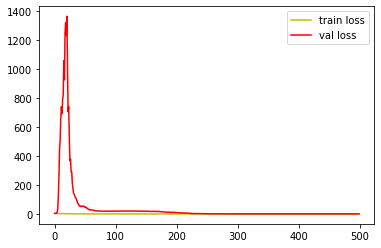

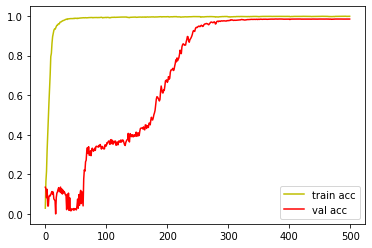

In [22]:
plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], 'y', label='train acc')
plt.plot(hist.history['val_accuracy'], 'r', label='val acc')
plt.legend()
plt.show()

In [23]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]


    plt.figure(figsize=(14,3))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])

    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0], 'gray')

    plt.subplot(1,4,3)
    preds_train = model.predict(input_)
    preds_train = np.argmax(preds_train, axis=-1).squeeze()
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train, 'gray')

    plt.subplot(1,4,4)
    plt.title("diff")
    plt.axis('off')
    plt.imshow(mask_[0]-preds_train, 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]

    plt.figure(figsize=(14,3))
    plt.subplot(1,4,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])

    plt.subplot(1,4,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0], 'gray')

    plt.subplot(1,4,3)
    preds_test = model.predict(input_)
    preds_test = np.argmax(preds_test, axis=-1).squeeze()
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test, 'gray')

    plt.subplot(1,4,4)
    plt.title("diff")
    plt.axis('off')
    plt.imshow(mask_[0]-preds_test, 'gray')
    plt.show()


1/1 [==============================] - 0s 23ms/step - loss: 0.0128 - accuracy: 0.9972


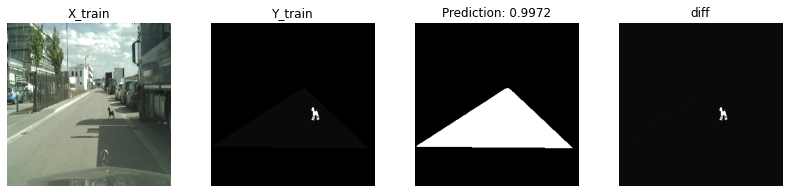

1/1 [==============================] - 0s 23ms/step - loss: 0.3003 - accuracy: 0.9833


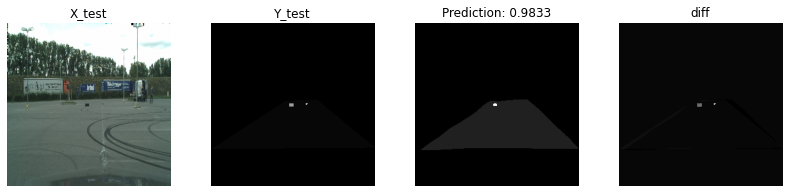

In [24]:
plotPredictions(model, train_x, train_y, test_x, test_y)